# Section 1 - Introduction

In this project, I will attempt to fit a function to model a pitcher's change in wOBA against for each of their pitch types as a function of the use of the pitch type. The long-term goal of this project is to optimize every pitcher's pitch mix. For this project, I define a pitcher's pitch mix as the percentage thrown of each of their pitch types.

For example, Cory Abbott's pitch mix in 2022 was 50.9% 4-Seam Fastball, 22.2% Knuckle Curve, 26.9% Slider.

For this project, I will also define an optimal pitch mix as the pitch mix that minimizes batter success against the pitcher.

Modeling pitcher performance as a single statistic is difficult. A successful result for a pitcher can come in many forms, and what is a successful result in one situation may not be successful in another situation. For example, two ground balls both in the same inning but one with the bases empty and the other with a runner on third base and less than two outs (assuming the defense is playing back) are very different outcomes for the pitcher. In the first case, the pitcher is likely to have generated an out, and in the other the pitcher likely generated an out, but allowed the run to score. Though the result of the plate appearance for the pitcher was the same, one situation represents a much better result for the pitcher.

The statistic that I've chosen to represent pitcher success is wOBA against (denoted wOBA from here on), you can read more about wOBA on Fangraphs. 

The first reason that I chose wOBA is that it better represents the value of events to a team's run scoring (or run prevention from the pitching team's perspective) than traditional batting stats.

The second reason that I chose wOBA is that it is limited to the results of a plate appearance. For a pitcher, getting looking or swinging strikes is generally good and throwing balls is generally bad, but their relationship to team run prevention is more complex than the relationship of the results of a plate appearance.

wOBA doesn't consider the situation of a plate appearance, so it isn't necessarily an improvement from the ground balls in the above example, but generally the lower wOBA a pitcher has, the better the pitcher will be at preventing runs.

When considering a pitcher's wOBA, we can turn it into a weighted average with their wOBA on each of their pitch types weighted by the percentage that they threw the pitch. 

Say a pitcher throws $n$ pitch types (denoted pitches from here on) (we will see later that the maximum number of pitches that a pitcher threw is 8).

Then we can create a weighted average of their pitch types like this

$wOBA = wOBA_{1} * x_{1} + ... + wOBA_{n} * x_{n}$

where $x_{i}$ is the percentage thrown of pitch $i$ across the full season

For example, the weighted average of Cory Abbott's wOBA is $0.363 = 0.329 * 0.509 + 0.374 * 0.222 + 0.422 * 0.269$

Part of what makes pitchers successful is ensuring that the batter doesn't know what pitch is coming next. So it is likely that if a pitcher throws a pitch type more or less often in a given time period, batters may have different results against that pitch in the time period.

My motivation for this project in the long-term comes from understanding that pitchers should throw their best pitches often, but in changing how often they throw each pitch they may see different results against it.

The motivation for this project is to model the relationship between a pitch's wOBA and its use.

For a pitch $i$, I want to determine

$\Delta wOBA_{i}(x_{i}) \approx \hat{wOBA}_{i} - wOBA_{i}$

where \hat{wOBA}_{i} is the wOBA of pitch $i$ in a sample of different use of pitch $i$.

That is, I want to approximate the change in wOBA for a different percent of use of pitch $i$.

The way that I will measure change in a pitch's use is against the average use of a pitch in the season. I will denote $\mu_{i}$ as the percentage thrown of pitch $i$ across the full season.

This makes the relationship that I seek to model as a function

$\Delta wOBA_{i}(x_{i}) = f(x_{i} - \mu_{i}) \approx \hat{wOBA}_{i} - wOBA_{i}$

# Section 2 - Loading Dataset

## Standard Library Imports

In [ ]:
I will import several Python libraries for data manipulation and data plotting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
I will also import two packages from the scikit-learn library for fitting models.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## Third-Party Library Imports

The last package that I will import is the statcast package, which I will use to gather the data.

In [ ]:
from pybaseball import statcast

The data that I will use to fit my model is from the entire 2022 MLB season

In [10]:
# load statcast dataset
pitches = statcast(start_dt="2022-04-07", end_dt="2022-10-05")

In [15]:
pitches.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3179,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213.0,0.035,-0.099
3366,FF,2022-10-05,97.7,-0.58,6.60,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189.0,0.052,-0.134
3520,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212.0,0.000,0.023
3682,FF,2022-10-05,97.2,-0.42,6.60,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192.0,0.000,-0.036
3854,SL,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127.0,0.000,-0.031


In [16]:
# number of pitches in dataset
len(pitches.index)

708540

# Section 3 - Data Cleaning

## Formatting Pitch Type

In [17]:
pitches.groupby(['pitch_type', 'pitch_name']).size()

pitch_type  pitch_name     
CH          Changeup            79427
CS          Slow Curve             96
CU          Curveball           54937
EP          Eephus                514
FA          Other                1269
FC          Cutter              51011
FF          4-Seam Fastball    235178
FS          Split-Finger        11206
KC          Knuckle Curve       15378
KN          Knuckleball            19
PO          Pitch Out              40
SI          Sinker             109385
SL          Slider             126166
ST          Sweeper             21085
SV          Slurve               2456
dtype: int64

In [18]:
# view pitchers who threw a slow curve
pitches[pitches['pitch_type'] == 'CS'][['pitch_type', 'player_name']].groupby('player_name').size()

player_name
Darvish, Yu          1
Duffey, Tyler       16
Gray, Sonny          6
Hill, Rich          19
McHugh, Collin      11
Mikolas, Miles       9
Ohtani, Shohei       1
Wainwright, Adam    33
dtype: int64

In [19]:
# merge slow curve with curveball
pitches = pitches.replace('CS', 'CU')
pitches = pitches.replace('Slow Curve', 'Curveball')

In [20]:
# view pitchers who threw an eephus
pitches[pitches['pitch_type'] == 'EP'][['pitch_type', 'player_name']].groupby('player_name').size()

player_name
Alberto, Hanser            1
Arcia, Orlando             8
Astudillo, Willians       17
Barnhart, Tucker           6
Batten, Matthew           23
Bethancourt, Christian    25
Bradley Jr., Jackie        3
Brosseau, Mike             1
Castillo, Diego           34
Castro, Harold            34
Chang, Yu                 22
Clemens, Kody             83
Dickerson, Corey           6
Escobar, Alcides           9
Gonzalez, Marwin           2
González, Luis            68
Knizner, Andrew            6
Lopez, Alejo              19
Molina, Yadier             1
Myers, Wil                 5
Neuse, Sheldon            24
Owings, Chris              9
Palacios, Jermaine         3
Peterson, Jace             7
Reyes, Pablo               8
Ruf, Darin                14
Schwindel, Frank          16
Stubbs, Garrett           15
Sánchez, Yolmer            7
VanMeter, Josh            12
Vargas, Ildemaro           4
Walton, Donovan           13
Wynns, Austin              9
dtype: int64

In [21]:
# view pitchers who threw a pitch classified as other
pitches[pitches['pitch_type'] == 'FA'][['pitch_type', 'player_name']].groupby('player_name').size()

player_name
Adrianza, Ehire            12
Alberto, Hanser           151
Arcia, Orlando              2
Astudillo, Willians         6
Barnhart, Tucker            1
Batten, Matthew             3
Bethancourt, Christian     27
Bradley Jr., Jackie        27
Brosseau, Mike             43
Caratini, Victor           14
Castillo, Diego            26
Castro, Harold             16
Chang, Yu                   2
Clemens, Kody               5
Clement, Ernie             32
Culberson, Charlie         26
Dickerson, Corey           12
Escobar, Alcides            3
Ford, Mike                 15
González, Luis             18
Gordon, Nick               85
Hager, Jake                28
Hall, Darick                6
Harrison, Josh             51
Kelly, Carson              68
Knizner, Andrew             4
León, Sandy                17
Lopez, Alejo                7
Lopez, Nicky               12
Maton, Nick                25
Mayfield, Jack              4
McKenna, Ryan              31
Merrifield, Whit           1

In [22]:
# view pitchers who threw a knuckleball
pitches[pitches['pitch_type'] == 'KN'][['pitch_type', 'player_name']].groupby('player_name').size()

player_name
Clement, Ernie      10
Mayfield, Jack       7
Schwindel, Frank     2
dtype: int64

In [23]:
# filter to remove EP, FA, KN, PO
pitches = pitches[pitches['pitch_type'].isin(['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV'])]

In [24]:
# number of pitches in modified and filtered dataset
len(pitches.index)

706325

In [25]:
# modified and filtered pitch types
pitches.groupby(['pitch_type', 'pitch_name']).size()

pitch_type  pitch_name     
CH          Changeup            79427
CU          Curveball           55033
FC          Cutter              51011
FF          4-Seam Fastball    235178
FS          Split-Finger        11206
KC          Knuckle Curve       15378
SI          Sinker             109385
SL          Slider             126166
ST          Sweeper             21085
SV          Slurve               2456
dtype: int64

In [26]:
def create_binary_pitch_type_column(pitch_type):
    # add boolean column for pitch_type thrown
    # add boolean column with pitch_type in lowercase letters
    pitches[pitch_type] = pitches['pitch_type'] == pitch_type
    # convert to binary
    pitches[pitch_type] = pitches[pitch_type].replace({True: 1, False: 0})

In [27]:
create_binary_pitch_type_column('CH')
create_binary_pitch_type_column('CU')
create_binary_pitch_type_column('FC')
create_binary_pitch_type_column('FF')
create_binary_pitch_type_column('FS')
create_binary_pitch_type_column('KC')
create_binary_pitch_type_column('SI')
create_binary_pitch_type_column('SL')
create_binary_pitch_type_column('ST')
create_binary_pitch_type_column('SV')

In [28]:
# check for pitch outside of desired pitches
pitches[(pitches['CH'] == 0) & (pitches['CU'] == 0) & (pitches['FC'] == 0) & (pitches['FF'] == 0) & (pitches['FS'] == 0) & (pitches['KC'] == 0) & (pitches['SI'] == 0) & (pitches['SL'] == 0) & (pitches['ST'] == 0) & (pitches['SV'] == 0)].head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,CH,CU,FC,FF,FS,KC,SI,SL,ST,SV


## Formatting Events

In [29]:
pitches.groupby('events').size()

events
catcher_interf                     74
caught_stealing_2b                209
caught_stealing_3b                 10
caught_stealing_home               12
double                           7894
double_play                       394
field_error                      1134
field_out                       73247
fielders_choice                   383
fielders_choice_out               282
force_out                        3812
game_advisory                       1
grounded_into_double_play        3368
hit_by_pitch                     2032
home_run                         5173
other_out                          32
pickoff_1b                         16
pickoff_2b                          2
pickoff_3b                          3
pickoff_caught_stealing_2b          2
pickoff_caught_stealing_3b          1
pickoff_caught_stealing_home        2
sac_bunt                          390
sac_fly                          1191
sac_fly_double_play                22
single                          25743
strik

In [30]:
def create_binary_events_column_single(event, column_name):
    # add boolean column for event
    pitches[column_name] = pitches['events'] == event
    # convert to binary
    pitches[column_name] = pitches[column_name].replace({True: 1, False: 0})

In [31]:
def create_binary_events_column_multiple(events, column_name):
    # add boolean column for events
    pitches[column_name] = pitches['events'].isin(events)
    # convert to binary
    pitches[column_name] = pitches[column_name].replace({True: 1, False: 0})

In [32]:
ab_events = ['double', 'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'other_out', 'single', 'strikeout', 'strikeout_double_play', 'triple', 'triple_play']
create_binary_events_column_multiple(ab_events, 'ab')

In [33]:
create_binary_events_column_single('single', 'x1b')
create_binary_events_column_single('double', 'x2b')
create_binary_events_column_single('triple', 'x3b')
create_binary_events_column_single('home_run', 'hr')
create_binary_events_column_single('walk', 'ubb')
create_binary_events_column_single('hit_by_pitch', 'hbp')

In [34]:
sf_events = ['sac_fly', 'sac_fly_double_play']
create_binary_events_column_multiple(sf_events, 'sf')

In [35]:
pitches.groupby('player_name')[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].sum().head()

,ab,x1b,x2b,x3b,hr,ubb,hbp,sf
player_name,,,,,,,,
"Abbott, Cory",184,20,12,0,12,25,5,2
"Abreu, Albert",144,25,5,0,5,22,3,2
"Abreu, Bryan",217,36,7,0,2,26,4,1
"Acevedo, Domingo",243,29,11,1,9,13,3,1
"Adam, Jason",211,22,3,1,5,15,6,2


# Section 4 - Calculating Pitch Use Percentages and wOBA Against

## Pitch Use in Full Season

In [36]:
pitch_use_full_season = pitches.groupby('player_name')[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg({'CH': 'mean', 'CU': 'mean', 'FC': 'mean', 'FF': 'mean', 'FS': 'mean', 'KC': 'mean', 'SI': 'mean', 'SL': 'mean', 'ST': 'mean', 'SV': 'mean'})
pitch_use_full_season = pitch_use_full_season.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3})

In [37]:
pitch_use_full_season.head()

,CH,CU,FC,FF,FS,KC,SI,SL,ST,SV
player_name,,,,,,,,,,
"Abbott, Cory",0.000,0.000,0.0,0.509,0.0,0.222,0.000,0.269,0.000,0.0
"Abreu, Albert",0.100,0.000,0.0,0.119,0.0,0.000,0.488,0.293,0.000,0.0
"Abreu, Bryan",0.003,0.101,0.0,0.450,0.0,0.000,0.004,0.442,0.000,0.0
"Acevedo, Domingo",0.221,0.000,0.0,0.424,0.0,0.000,0.009,0.346,0.000,0.0
"Adam, Jason",0.322,0.000,0.0,0.321,0.0,0.000,0.000,0.000,0.358,0.0


In [38]:
pitch_use_full_season = pitch_use_full_season.stack()
pitch_use_full_season = pitch_use_full_season.to_frame().rename(columns={0: 'pct'})
pitch_use_full_season = pitch_use_full_season.rename_axis(['player_name', 'pitch_type'])

In [40]:
pitch_use_full_season = pitch_use_full_season[pitch_use_full_season['pct'] > 0]

In [41]:
pitch_use_full_season.head()

pct
player_name   pitch_type       
Abbott, Cory  FF          0.509
              KC          0.222
              SL          0.269
Abreu, Albert CH          0.100
              FF          0.119

In [42]:
pitch_rank_full_season = pitch_use_full_season.groupby('player_name').rank(method='min', ascending=False)
pitch_rank_full_season['pct'] = pitch_rank_full_season['pct'].apply(np.int64)
pitch_rank_full_season = pitch_rank_full_season.rename(columns={'pct': 'use'})

In [43]:
pitch_rank_full_season.head()

use
player_name   pitch_type     
Abbott, Cory  FF            1
              KC            3
              SL            2
Abreu, Albert CH            4
              FF            3

In [44]:
pitch_rank_full_season.describe()

,use
count,3397.000000
mean,2.720636
std,1.416490
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,8.000000


In [45]:
pitch_rank_full_season['use'] = pitch_rank_full_season['use'].replace({1: 'first', 2: 'second', 3: 'third', 4: 'fourth', 5: 'fifth', 6: 'sixth', 7: 'seventh', 8: 'eighth'})

In [46]:
pitch_rank_full_season.head()

use
player_name   pitch_type        
Abbott, Cory  FF           first
              KC           third
              SL          second
Abreu, Albert CH          fourth
              FF           third

In [47]:
num_pitches = pitch_use_full_season.groupby('player_name').size()

In [49]:
num_pitches[num_pitches == 1]

player_name
Culberson, Charlie    1
Dozier, Hunter        1
Escobar, Alcides      1
Gonzalez, Marwin      1
Gosselin, Phil        1
Harrison, Josh        1
Knizner, Andrew       1
Lopez, Nicky          1
Mayfield, Jack        1
McGuire, Reese        1
Merrifield, Whit      1
Neuse, Sheldon        1
Plawecki, Kevin       1
Pujols, Albert        1
Reynolds, Matt        1
Simmons, Andrelton    1
Torrens, Luis         1
Wynns, Austin         1
dtype: int64

In [50]:
two_or_more_pitches = num_pitches[num_pitches > 1]
two_or_more_pitches = two_or_more_pitches.to_frame().rename(columns={0: 'num_pitches'})

In [51]:
two_or_more_pitches.head()

,num_pitches
player_name,
"Abbott, Cory",3
"Abreu, Albert",4
"Abreu, Bryan",5
"Acevedo, Domingo",4
"Adam, Jason",3


In [52]:
len(two_or_more_pitches.index)

810

In [53]:
pitch_rank_full_season = pitch_rank_full_season.join(two_or_more_pitches, how='inner')

In [55]:
pitch_rank_full_season = pitch_rank_full_season[['use']]

In [56]:
pitch_rank_full_season.head()

use
player_name   pitch_type        
Abbott, Cory  FF           first
              KC           third
              SL          second
Abreu, Albert CH          fourth
              FF           third

In [57]:
len(pitch_rank_full_season.index)

3379

In [58]:
pitch_use_full_season = pitch_use_full_season.join(pitch_rank_full_season, how='inner')

In [59]:
pitch_use_full_season.head()

pct     use
player_name   pitch_type               
Abbott, Cory  FF          0.509   first
              KC          0.222   third
              SL          0.269  second
Abreu, Albert CH          0.100  fourth
              FF          0.119   third

## Pitch Use by Appearance

In [60]:
pitch_use_appearance = pitches.groupby(['player_name', 'game_pk'])[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg({'CH': 'mean', 'CU': 'mean', 'FC': 'mean', 'FF': 'mean', 'FS': 'mean', 'KC': 'mean', 'SI': 'mean', 'SL': 'mean', 'ST': 'mean', 'SV': 'mean'})
pitch_use_appearance = pitch_use_appearance.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3})

In [61]:
pitch_use_appearance.head()

CH   CU   FC     FF   FS     KC   SI     SL   ST   SV
player_name  game_pk                                                        
Abbott, Cory 661094   0.0  0.0  0.0  0.636  0.0  0.170  0.0  0.193  0.0  0.0
             661470   0.0  0.0  0.0  0.377  0.0  0.188  0.0  0.435  0.0  0.0
             661558   0.0  0.0  0.0  0.494  0.0  0.228  0.0  0.278  0.0  0.0
             661593   0.0  0.0  0.0  0.500  0.0  0.125  0.0  0.375  0.0  0.0
             661924   0.0  0.0  0.0  0.466  0.0  0.409  0.0  0.125  0.0  0.0

In [62]:
pitch_use_appearance = pitch_use_appearance.stack()
pitch_use_appearance = pitch_use_appearance.to_frame().rename(columns={0: 'pct'})
pitch_use_appearance = pitch_use_appearance.rename_axis(['player_name', 'game_pk', 'pitch_type'])

In [63]:
pitch_use_appearance.head()

pct
player_name  game_pk pitch_type       
Abbott, Cory 661094  CH          0.000
                     CU          0.000
                     FC          0.000
                     FF          0.636
                     FS          0.000

In [64]:
pitch_use_appearance = pitch_use_appearance[pitch_use_appearance['pct'] > 0]

In [66]:
pitch_count_appearance = pitches.groupby(['player_name', 'game_pk']).size()
pitch_count_appearance = pitch_count_appearance.to_frame().rename(columns={0: 'pitch_count'})

In [67]:
pitch_count_appearance.head()

pitch_count
player_name  game_pk             
Abbott, Cory 661094            88
             661470            69
             661558            79
             661593             8
             661924            88

In [68]:
pitch_count_quartiles = pitch_count_appearance.groupby('player_name').quantile(q=[i / 4 for i in range(1, 5)], interpolation='linear')
pitch_count_quartiles = pitch_count_quartiles.rename_axis(['player_name', 'quartile'])

In [69]:
pitch_count_quartiles.head()

pitch_count
player_name   quartile             
Abbott, Cory  0.25             18.5
              0.50             70.5
              0.75             83.0
              1.00             90.0
Abreu, Albert 0.25             15.0

In [70]:
pitch_count_first_quartile = pitch_count_quartiles.xs(0.25, level=1)
pitch_count_first_quartile = pitch_count_first_quartile.rename(columns={'pitch_count': 'first_quartile'})

pitch_count_third_quartile = pitch_count_quartiles.xs(0.75, level=1)
pitch_count_third_quartile = pitch_count_third_quartile.rename(columns={'pitch_count': 'third_quartile'})

In [73]:
pitch_count_appearance = pitch_count_appearance.join(pitch_count_first_quartile, how='inner')

In [74]:
pitch_count_appearance = pitch_count_appearance.join(pitch_count_third_quartile, how='inner')

In [75]:
pitch_count_appearance.head()

pitch_count  first_quartile  third_quartile
player_name  game_pk                                             
Abbott, Cory 661094            88            18.5            83.0
             661470            69            18.5            83.0
             661558            79            18.5            83.0
             661593             8            18.5            83.0
             661924            88            18.5            83.0

In [76]:
pitch_count_appearance['interquartile_range'] = pitch_count_appearance['third_quartile'] - pitch_count_appearance['first_quartile']

In [77]:
pitch_count_appearance.head()

pitch_count  first_quartile  third_quartile  \
player_name  game_pk                                                
Abbott, Cory 661094            88            18.5            83.0   
             661470            69            18.5            83.0   
             661558            79            18.5            83.0   
             661593             8            18.5            83.0   
             661924            88            18.5            83.0   

                      interquartile_range  
player_name  game_pk                       
Abbott, Cory 661094                  64.5  
             661470                  64.5  
             661558                  64.5  
             661593                  64.5  
             661924                  64.5

In [78]:
pitch_count_appearance['lower_outlier'] = pitch_count_appearance['pitch_count'] <= pitch_count_appearance['first_quartile'] - 1.5 * pitch_count_appearance['interquartile_range']
pitch_count_appearance['lower_outlier'] = pitch_count_appearance['lower_outlier'].replace({True: 1, False: 0})

pitch_count_appearance['higher_outlier'] = pitch_count_appearance['pitch_count'] >= pitch_count_appearance['third_quartile'] + 1.5 * pitch_count_appearance['interquartile_range']
pitch_count_appearance['higher_outlier'] = pitch_count_appearance['higher_outlier'].replace({True: 1, False: 0})

In [79]:
pitch_count_appearance.head()

pitch_count  first_quartile  third_quartile  \
player_name  game_pk                                                
Abbott, Cory 661094            88            18.5            83.0   
             661470            69            18.5            83.0   
             661558            79            18.5            83.0   
             661593             8            18.5            83.0   
             661924            88            18.5            83.0   

                      interquartile_range  lower_outlier  higher_outlier  
player_name  game_pk                                                      
Abbott, Cory 661094                  64.5              0               0  
             661470                  64.5              0               0  
             661558                  64.5              0               0  
             661593                  64.5              0               0  
             661924                  64.5              0               0

In [80]:
pitch_count_appearance['outlier'] = pitch_count_appearance['lower_outlier'] + pitch_count_appearance['higher_outlier']

In [81]:
pitch_count_appearance = pitch_count_appearance[['pitch_count', 'outlier']]

In [82]:
pitch_use_appearance = pitch_use_appearance.join(pitch_count_appearance, how='inner')

In [83]:
pitch_count_appearance[pitch_count_appearance['outlier'] == 2]

pitch_count  outlier
player_name              game_pk                      
Adams, Austin            662104            24        2
                         663395            24        2
Alldred, Cam             662372            16        2
Alvarez, R.J.            661495            51        2
Anderson, Shaun          661740            21        2
...                                       ...      ...
Torrens, Luis            662200             1        2
Valdez, César            661126            16        2
Walters, Nash            662421            16        2
Weathers, Ryan           663155            89        2
Woods Richardson, Simeon 662769            91        2

[65 rows x 2 columns]

## wOBA Against in Full Season

In [84]:
wx1b = 0.884
wx2b = 1.261
wx3b = 1.601
whr = 2.072
wubb = 0.689
whbp = 0.720

In [85]:
woba_full_season = pitches.groupby(['player_name', 'pitch_type'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})

In [87]:
woba_full_season['woba'] = ((wx1b * woba_full_season['x1b']) + (wx2b * woba_full_season['x2b']) + (wx3b * woba_full_season['x3b']) + (whr * woba_full_season['hr']) + (wubb * woba_full_season['ubb']) + (whbp * woba_full_season['hbp'])) / (woba_full_season['ab'] + woba_full_season['ubb'] + woba_full_season['hbp'] + woba_full_season['sf'])
woba_full_season = woba_full_season.round({'woba': 3})

In [89]:
woba_full_season = woba_full_season[['woba']]

In [90]:
woba_full_season.head()

woba
player_name   pitch_type       
Abbott, Cory  FF          0.329
              KC          0.374
              SL          0.422
Abreu, Albert CH          0.476
              FF          0.543

## wOBA Against by Appearance

In [91]:
woba_appearance = pitches.groupby(['player_name', 'game_pk', 'pitch_type'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})

In [93]:
woba_appearance['woba'] = ((wx1b * woba_appearance['x1b']) + (wx2b * woba_appearance['x2b']) + (wx3b * woba_appearance['x3b']) + (whr * woba_appearance['hr']) + (wubb * woba_appearance['ubb']) + (whbp * woba_appearance['hbp'])) / (woba_appearance['ab'] + woba_appearance['ubb'] + woba_appearance['hbp'] + woba_appearance['sf'])
woba_appearance = woba_appearance.round({'woba': 3})

In [95]:
woba_appearance = woba_appearance[['woba']]

In [96]:
woba_appearance.head()

woba
player_name  game_pk pitch_type       
Abbott, Cory 661094  FF          0.418
                     KC          0.589
                     SL          0.440
             661470  FF          0.394
                     KC          0.442

# Section 5 - Creating the Games DataFrame 

In [97]:
appearances = woba_appearance.join(pitch_use_appearance, how='inner')

In [99]:
appearances = appearances.rename(columns={'woba': 'woba_appearance', 'pct': 'pct_appearance'})

In [100]:
appearances.head()

woba_appearance  pct_appearance  pitch_count  \
player_name  game_pk pitch_type                                                 
Abbott, Cory 661094  FF                    0.418           0.636           88   
                     KC                    0.589           0.170           88   
                     SL                    0.440           0.193           88   
             661470  FF                    0.394           0.377           69   
                     KC                    0.442           0.188           69   

                                 outlier  
player_name  game_pk pitch_type           
Abbott, Cory 661094  FF                0  
                     KC                0  
                     SL                0  
             661470  FF                0  
                     KC                0

In [101]:
appearances = appearances.join(woba_full_season, how='inner')

In [103]:
appearances = appearances.join(pitch_use_full_season, how='inner')

In [105]:
appearances = appearances.rename(columns={'woba': 'woba_full_season', 'pct': 'pct_full_season'})

In [106]:
appearances.head()

woba_appearance  pct_appearance  pitch_count  \
player_name  pitch_type game_pk                                                 
Abbott, Cory FF         661094             0.418           0.636           88   
                        661470             0.394           0.377           69   
                        661558             0.795           0.494           79   
                        661593             0.000           0.500            8   
                        661924             0.429           0.466           88   

                                 outlier  woba_full_season  pct_full_season  \
player_name  pitch_type game_pk                                               
Abbott, Cory FF         661094         0             0.329            0.509   
                        661470         0             0.329            0.509   
                        661558         0             0.329            0.509   
                        661593         0             0.329            0.509   
                        661924         0             0.329            0.509   

                                   use  
player_name  pitch_type game_pk         
Abbott, Cory FF         661094   first  
                        661470   first  
                        661558   first  
                        661593   first  
                        661924   first

In [107]:
appearances.describe()

,woba_appearance,pct_appearance,pitch_count,outlier,woba_full_season,pct_full_season
count,54431.000000,68600.000000,68600.000000,68600.000000,68266.000000,68600.000000
mean,0.303953,0.302376,40.401152,0.037143,0.306393,0.286872
std,0.373876,0.201265,33.311503,0.200560,0.120951,0.170897
min,0.000000,0.009000,1.000000,0.000000,0.000000,0.001000
25%,0.000000,0.141000,14.000000,0.000000,0.241000,0.153000
50%,0.221000,0.267000,23.000000,0.000000,0.298000,0.270000
75%,0.452000,0.429000,77.000000,0.000000,0.358000,0.403000
max,2.072000,1.000000,129.000000,2.000000,2.072000,0.913000


In [108]:
appearances = appearances[(appearances['woba_appearance'].notnull()) & (appearances['woba_full_season'].notnull())]

In [109]:
appearances.describe()

,woba_appearance,pct_appearance,pitch_count,outlier,woba_full_season,pct_full_season
count,54431.000000,54431.000000,54431.000000,54431.000000,54431.000000,54431.000000
mean,0.303953,0.340403,43.592163,0.038673,0.305241,0.312760
std,0.373876,0.199336,34.126340,0.204469,0.104865,0.169177
min,0.000000,0.009000,1.000000,0.000000,0.000000,0.001000
25%,0.000000,0.183000,15.000000,0.000000,0.246000,0.183000
50%,0.221000,0.312000,25.000000,0.000000,0.299000,0.295000
75%,0.452000,0.467000,81.000000,0.000000,0.355000,0.430000
max,2.072000,1.000000,129.000000,2.000000,2.072000,0.913000


In [110]:
appearances['woba_diff'] = appearances['woba_appearance'] - appearances['woba_full_season']
appearances['pct_diff'] = appearances['pct_appearance'] - appearances['pct_full_season']

In [111]:
appearances.head()

woba_appearance  pct_appearance  pitch_count  \
player_name  pitch_type game_pk                                                 
Abbott, Cory FF         661094             0.418           0.636           88   
                        661470             0.394           0.377           69   
                        661558             0.795           0.494           79   
                        661593             0.000           0.500            8   
                        661924             0.429           0.466           88   

                                 outlier  woba_full_season  pct_full_season  \
player_name  pitch_type game_pk                                               
Abbott, Cory FF         661094         0             0.329            0.509   
                        661470         0             0.329            0.509   
                        661558         0             0.329            0.509   
                        661593         0             0.329            0.509   
                        661924         0             0.329            0.509   

                                   use  woba_diff  pct_diff  
player_name  pitch_type game_pk                              
Abbott, Cory FF         661094   first      0.089     0.127  
                        661470   first      0.065    -0.132  
                        661558   first      0.466    -0.015  
                        661593   first     -0.329    -0.009  
                        661924   first      0.100    -0.043

In [112]:
appearances.describe()

,woba_appearance,pct_appearance,pitch_count,outlier,woba_full_season,pct_full_season,woba_diff,pct_diff
count,54431.000000,54431.000000,54431.000000,54431.000000,54431.000000,54431.000000,54431.000000,54431.000000
mean,0.303953,0.340403,43.592163,0.038673,0.305241,0.312760,-0.001288,0.027644
std,0.373876,0.199336,34.126340,0.204469,0.104865,0.169177,0.358392,0.119799
min,0.000000,0.009000,1.000000,0.000000,0.000000,0.001000,-1.036000,-0.530000
25%,0.000000,0.183000,15.000000,0.000000,0.246000,0.183000,-0.261000,-0.044000
50%,0.221000,0.312000,25.000000,0.000000,0.299000,0.295000,-0.087000,0.016000
75%,0.452000,0.467000,81.000000,0.000000,0.355000,0.430000,0.162000,0.089000
max,2.072000,1.000000,129.000000,2.000000,2.072000,0.913000,1.951000,0.942000


# Section 6 - Data Analysis

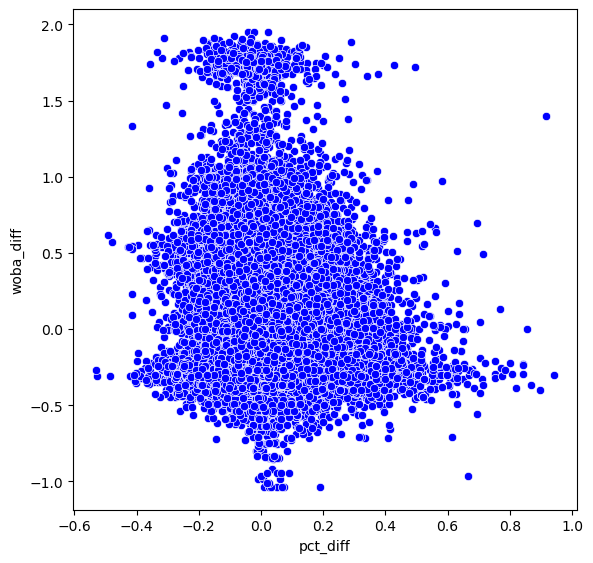

In [113]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', data=appearances, ax=ax);

## One Degree Model

In [114]:
# set fit_intercept=False as we want f(mu_i) = 0
# that is that we can recreate the pitcher's season wOBA with their full season pitch use
x_all_pitches = appearances['pct_diff'].to_numpy().reshape(-1, 1)
y_all_pitches = appearances['woba_diff'].to_numpy()
model_all_pitches_deg1 = LinearRegression(fit_intercept=False).fit(x_all_pitches, y_all_pitches)
slope_all_pitches_deg1 = model_all_pitches_deg1.coef_[0]
r_squared_all_pitches_deg1 = model_all_pitches_deg1.score(x_all_pitches, y_all_pitches)

In [115]:
print(f"slope: {slope_all_pitches_deg1}")
print(f"coefficient of determination: {r_squared_all_pitches_deg1}")

slope: -0.27852850331049855
coefficient of determination: 0.009116853587978646


In [116]:
x_all_pitches = x_all_pitches.reshape(-1)
y_hat_all_pitches_deg1 = slope_all_pitches_deg1 * x_all_pitches
res_all_pitches_deg1 = np.subtract(y_hat_all_pitches_deg1, y_all_pitches)
mse_all_pitches_deg1 = np.square(res_all_pitches_deg1).mean()
rmse_all_pitches_deg1 = np.sqrt(mse_all_pitches_deg1)

In [117]:
print(f"rmse: {rmse_all_pitches_deg1}")

rmse: 0.35675142241285746


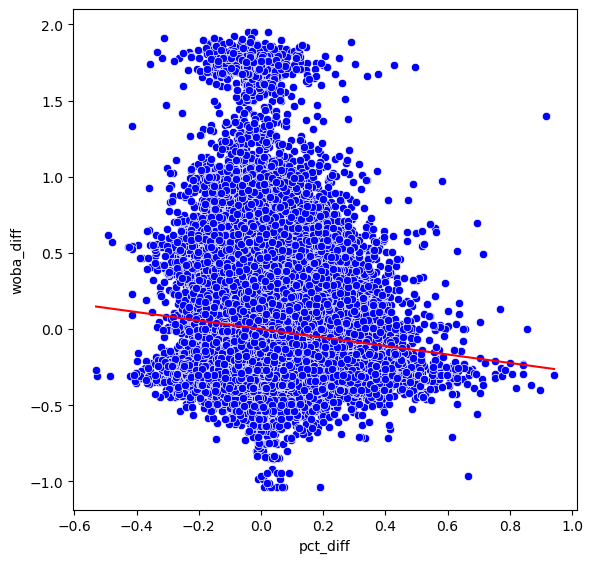

In [118]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', data=appearances, ax=ax);
# ax.axline((0, 0), slope=slope_all_pitches, c='r');

x_values = np.linspace(appearances['pct_diff'].min(), appearances['pct_diff'].max(), 1000)
y_values = slope_all_pitches_deg1 * x_values

sns.lineplot(x=x_values, y=y_values, color='red');

## Three Degree Model

In [119]:
x_all_pitches = appearances['pct_diff'].to_numpy().reshape(-1, 1)
x_all_pitches_ = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x_all_pitches)
model_all_pitches_deg3 = LinearRegression(fit_intercept=False).fit(x_all_pitches_, y_all_pitches)
slope_all_pitches_deg3_0 = model_all_pitches_deg3.coef_[0]
slope_all_pitches_deg3_1 = model_all_pitches_deg3.coef_[1]
slope_all_pitches_deg3_2 = model_all_pitches_deg3.coef_[2]
r_squared_all_pitches_deg3 = model_all_pitches_deg3.score(x_all_pitches_, y_all_pitches)

In [120]:
print(f"slope degree 1: {slope_all_pitches_deg3_0}")
print(f"slope degree 2: {slope_all_pitches_deg3_1}")
print(f"slope degree 3: {slope_all_pitches_deg3_2}")
print(f"coefficient of determination: {r_squared_all_pitches_deg3}")

slope degree 1: -0.2866778568201429
slope degree 2: -0.1257199273562069
slope degree 3: 0.3202505431314719
coefficient of determination: 0.009207059414285235


In [121]:
x_all_pitches = x_all_pitches.reshape(-1)
y_hat_all_pitches_deg3 = slope_all_pitches_deg3_0 * x_all_pitches + slope_all_pitches_deg3_1 * np.power(x_all_pitches, 2) + slope_all_pitches_deg3_2 * np.power(x_all_pitches, 3)
res_all_pitches_deg3 = np.subtract(y_hat_all_pitches_deg3, y_all_pitches)
mse_all_pitches_deg3 = np.square(res_all_pitches_deg3).mean()
rmse_all_pitches_deg3 = np.sqrt(mse_all_pitches_deg3)

In [122]:
print(f"rmse: {rmse_all_pitches_deg3}")

rmse: 0.3567351834701518


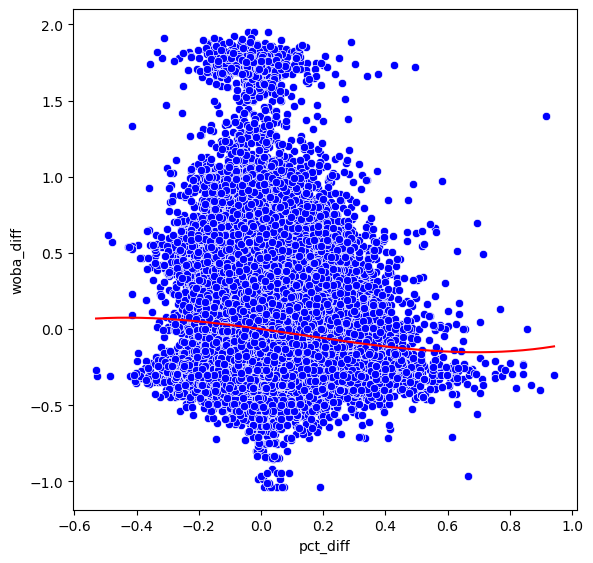

In [123]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', data=appearances, ax=ax);
# ax.axline((0, 0), slope=slope_all_pitches, c='r');

x_values = np.linspace(appearances['pct_diff'].min(), appearances['pct_diff'].max(), 1000)
y_values = slope_all_pitches_deg3_0 * x_values + slope_all_pitches_deg3_1 * np.power(x_values, 2) + slope_all_pitches_deg3_2 * np.power(x_values, 3)

sns.lineplot(x=x_values, y=y_values, color='red');

## Outliers

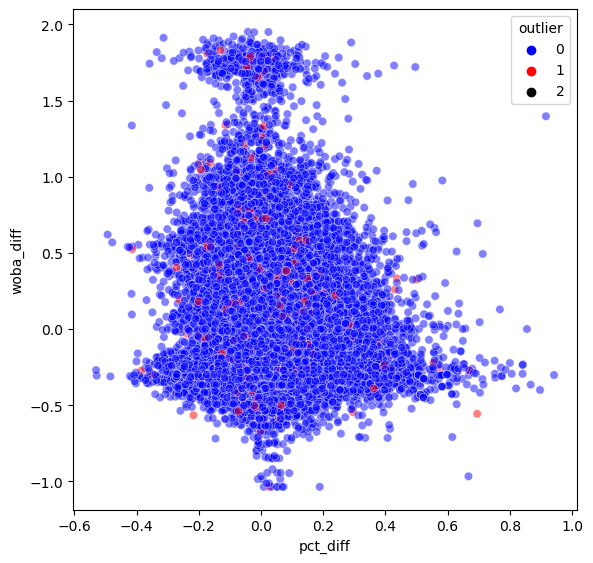

In [124]:
colors = {0: 'blue', 1: 'red', 2: 'black'}

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x='pct_diff', y='woba_diff', hue='outlier', alpha=0.5, palette=colors, data=appearances, ax=ax);

In [125]:
x_no_outliers = appearances[appearances['outlier'] == 0]['pct_diff'].to_numpy().reshape(-1, 1)
y_no_outliers = appearances[appearances['outlier'] == 0]['woba_diff'].to_numpy()
model_no_outliers_deg1 = LinearRegression(fit_intercept=False).fit(x_no_outliers, y_no_outliers)
slope_no_outliers_deg1 = model_no_outliers_deg1.coef_[0]
r_squared_no_outliers_deg1 = model_no_outliers_deg1.score(x_no_outliers, y_no_outliers)

In [126]:
print(f"slope: {slope_no_outliers_deg1}")
print(f"coefficient of determination: {r_squared_no_outliers_deg1}")

slope: -0.2790492428229659
coefficient of determination: 0.00916151344482008


In [127]:
x_no_outliers = x_no_outliers.reshape(-1)
y_hat_no_outliers_deg1 = slope_no_outliers_deg1 * x_no_outliers
res_no_outliers_deg1 = np.subtract(y_hat_no_outliers_deg1, y_no_outliers)
mse_no_outliers_deg1 = np.square(res_no_outliers_deg1).mean()
rmse_no_outliers_deg1 = np.sqrt(mse_no_outliers_deg1)

In [128]:
print(f"rmse: {rmse_no_outliers_deg1}")

rmse: 0.35687630900987766


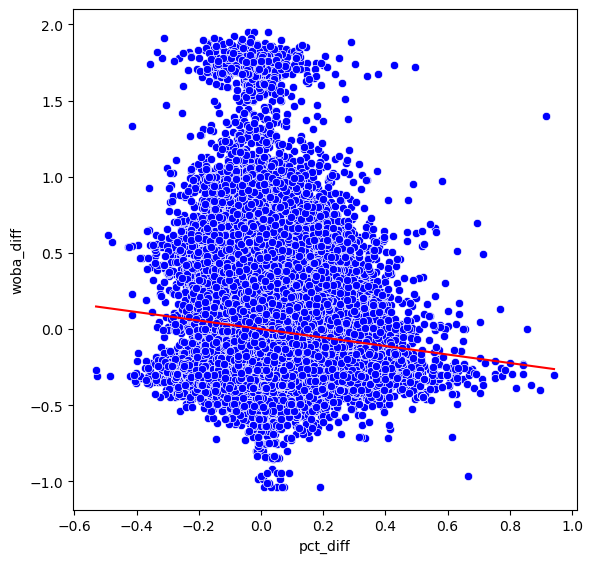

In [129]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', data=appearances[appearances['outlier'] == 0], ax=ax);
# ax.axline((0, 0), slope=slope_all_pitches, c='r');

x_values = np.linspace(appearances['pct_diff'].min(), appearances['pct_diff'].max(), 1000)
y_values = slope_no_outliers_deg1 * x_values

sns.lineplot(x=x_values, y=y_values, color='red');

## Analysis of Models

In [132]:
model_performance_df = {'Model': ['one degree', 'three degrees', 'one degree no outliers'],
                       'R Squared': [r_squared_all_pitches_deg1, r_squared_all_pitches_deg3, r_squared_no_outliers_deg1],
                       'RMSE': [rmse_all_pitches_deg1, rmse_all_pitches_deg3, rmse_no_outliers_deg1]}
model_performance_df = pd.DataFrame(data=model_performance_df)

In [133]:
model_performance_df

,Model,R Squared,RMSE
0,one degree,0.009117,0.356751
1,three degrees,0.009207,0.356735
2,one degree no outliers,0.009162,0.356876


# Section 7 - Conclusion

The best performing model that I had was the three degree model. That is, for pitch $i$

$\Delta wOBA_{i}(x_{i}) = 0.3203 * (x_{i} - \mu_{i})^{3} - 0.1257 * (x_{i} - \mu_{i})^{2} - 0.2867 * (x_{i} - \mu_{i})$

However, none of the models performed particularly well. Variation in pitch use, relative to their season average, explained, at best, only 0.91% of the variation in wOBA difference, and the models were, at best, within 0.3567 of their true wOBA in each appearance.

These are poorly performing models for my long-term goal. The next steps that I plan to take to improve my model fit is to determining a better model is 

1) To fit a model for each pitch type, creating 10 different models for each of the 10 pitch types.

For example, I would fit a model for Changeups. Then I can determine each model's R Squared and RMSE to see if there is improvement over these models.

2) To fit a model for each pitch use, creating 8 different models for each of the 8 different pitch uses.

For example, I would fit a model for each pitcher's most commonly thrown pitch. Then I can determine each model's R Squared and RMSE to see if there is an improvement over these models.

3) To determine the minumum sample size for wOBA to be stable. If the sample size for wOBA to be stable is larger than most pitcher's appearances, then I will bin the data into samples of this minimum sample size.